### analysis/process_and_save_sims_ORN_LN_PN_resampling_with_PN_synapse_density.ipynb

For ORN/LN/PN bootstraps in which total PN synaptic input was also varied of the model chosen from the parameter sweep (where ORN columns are scaled by 0.1, eLNs by 0.04, iLNs by 0.02, and PNs by 0.4), 
- compares PN firing rate vectors of simulated ALs to PN calcium responses in real flies
- performs PCA to compare loadings to those of PN calcium responses in real flies
- saves PCA loadings for grand PCA analysis in analysis/analyze_all_simulation_PCAs.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib.lines import Line2D
import pickle
import sys
import os
file_path = 'C:/Users/dB/deBivort/projects/ALVariability/'
proj_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
sys.path.append(proj_dir)
from utils.plot_utils import set_font_sizes
from utils.data_utils import make_df_AL_activity_long, make_orn_upn_frs, make_glomerular_odor_responses
set_font_sizes()

In [2]:
project_dir = os.path.join(file_path.split('ALVariability')[0], 'ALVariability')
df_neur_ids = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/df_neur_ids.csv'), index_col=0)
al_block = pd.read_csv(os.path.join(project_dir, 'connectomics/hemibrain_v1_2/AL_block.csv'), index_col=0)
al_block.columns = al_block.columns.astype(np.int64)
al_block.index = al_block.index.astype(np.int64)
imput_table = pd.read_csv(os.path.join(project_dir, 'odor_imputation/df_odor_door_all_odors_imput_ALS.csv'), index_col=0)

In [3]:
d_sims_fpath1 = '../run_model/save_sims_resampling_ORNs_LNs_PNs_adjustGlomSynapses/d_sims_res_df_AL_activities_2021_6_24-12_48_34.p'
d_sims1 = pickle.load(open(d_sims_fpath1, 'rb'))

In [4]:
d_sims_fpath2 = '../run_model/save_sims_resampling_ORNs_LNs_PNs_adjustGlomSynapses2/d_sims_res_df_AL_activities_2021_7_13-20_45_16.p'
d_sims2 = pickle.load(open(d_sims_fpath2, 'rb'))

d_sims_fpath3 = '../run_model/save_sims_resampling_ORNs_LNs_PNs_adjustGlomSynapses3/d_sims_res_df_AL_activities_2021_7_14-10_26_27.p'
d_sims3 = pickle.load(open(d_sims_fpath3, 'rb'))

d_sims_fpath4 = '../run_model/save_sims_resampling_ORNs_LNs_PNs_adjustGlomSynapses4/d_sims_res_df_AL_activities_2021_7_23-17_16_12.p'
d_sims4 = pickle.load(open(d_sims_fpath4, 'rb'))

In [5]:
d_sims = {**d_sims1, **d_sims2, **d_sims3, **d_sims4}

In [6]:
sim_dirs = list(d_sims.keys())
sim_dirs[:5]

['2021_6_24-10_38_54__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__10_38_54',
 '2021_6_24-10_43_53__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__10_43_53',
 '2021_6_23-16_11_35__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_LN_adjustPNInputs__16_11_35',
 '2021_6_23-15_50_19__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_ORN_adjustPNInputs__15_50_19',
 '2021_6_23-16_39_32__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_umPN_adjustPNInputs__16_39_32']

In [7]:
len(sim_dirs)

5332

In [8]:
orn_set = [f for f in sim_dirs if 'resample_ORN_adjust' in f]
ln_set = [f for f in sim_dirs if 'resample_LN_adjust' in f]
pn_set = [f for f in sim_dirs if 'resample_umPN_adjust' in f]

ln_pn_set = [f for f in sim_dirs if 'resample_LN_umPN_adjust' in f]
orn_pn_set = [f for f in sim_dirs if 'resample_ORN_umPN_adjust' in f]
orn_ln_set = [f for f in sim_dirs if 'resample_ORN_LN_adjust' in f]

none_set = [f for f in sim_dirs if 'resample_adjust' in f]
all_set = [f for f in sim_dirs if 'resample_ORN_LN_umPN_adjust' in f]


list_of_sets = [none_set, orn_set, ln_set, pn_set, 
                #ln_pn_set, orn_pn_set, orn_ln_set, 
                all_set]
#list_of_sets = [none_set, orn_set, ln_set, pn_set, all_set]

set_names = ['No resampling (PN cone)', '+ ORN (PN cone)', '+ LN (PN cone)', '+ PN (PN cone)',
             '+ ORN + LN + PN (PN cone)']

all_sims = np.concatenate(list_of_sets)
all_sims_short_names = np.concatenate([[set_names[i]]*len(list_of_sets[i]) for i in range(len(list_of_sets))])

In [9]:
master_fig_dir = os.path.join(os.curdir, 'figs')
if not os.path.exists(master_fig_dir):
    os.makedirs(master_fig_dir)
resampling_fig_dir = os.path.join(master_fig_dir, 'resample_ORNs_LNs_PNs_PNdensity')
if not os.path.exists(resampling_fig_dir):
    os.makedirs(resampling_fig_dir)

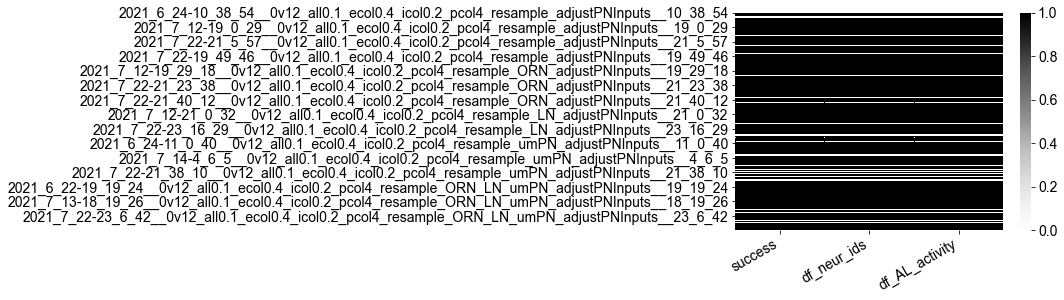

In [10]:
sim_info_fields = np.array(['success', 'df_neur_ids', 'df_AL_activity'])
success_pos = np.where(sim_info_fields == 'success')[0][0]

df_sim_info = []
for i in range(len(all_sims)):
    s = all_sims[i]
    sim_keys = list(d_sims[s].keys())
    present_keys = [f in sim_keys for f in sim_info_fields]
    present_keys[success_pos] = d_sims[s]['success']
    #r = pd.Series(present_keys, name=all_sims_short_names[i]).T
    r = pd.Series(present_keys, name=s).T
    df_sim_info.append(r)
df_sim_info = pd.concat(df_sim_info, 1).T
df_sim_info.columns = sim_info_fields
df_sim_info = df_sim_info.astype(int)

plt.figure()
sns.heatmap(df_sim_info, cmap='Greys')
plt.xticks(rotation=30, ha='right')
plt.show()

In [11]:
df_sim_info.iloc[:5]

,success,df_neur_ids,df_AL_activity
2021_6_24-10_38_54__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__10_38_54,1,1,1
2021_6_24-10_43_53__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__10_43_53,1,1,1
2021_6_24-10_41_24__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__10_41_24,1,1,1
2021_6_24-10_42_1__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__10_42_1,1,1,1
2021_6_24-1_13_23__0v12_all0.1_ecol0.4_icol0.2_pcol4_resample_adjustPNInputs__1_13_23,1,1,1


In [12]:
list_of_sets_good_sims = [df_sim_info[(df_sim_info.success == 1) & 
                                      (df_sim_info.index.isin(cur_set))].index.values \
                          for cur_set in list_of_sets]
all_good_sims = np.concatenate(list_of_sets_good_sims)
all_good_sims_short_names = np.concatenate([[set_names[i]]*len(list_of_sets_good_sims[i])\
                                            for i in range(len(list_of_sets_good_sims))])

In [13]:
[len(x) for x in list_of_sets_good_sims], len(all_good_sims)

([986, 980, 968, 941, 964], 4839)

In [14]:
set_names = [f'{set_names[i]} ({len(list_of_sets_good_sims[i])})' for i in range(len(set_names))]

In [15]:
#df_char_ids = d_sims[good_orn_set[0]]['df_char_ids']
#hemi_gloms = df_char_ids[df_char_ids['altype'] == 'ORN']['glom'].unique()
hemi_gloms = np.array(['DA1', 'VC5', 'VA1v', 'VA1d', 'VA2', 'VA6', 'DM1', 'DL3', 'DL1',
       'VL2a', 'VM4', 'VM5d', 'DM2', 'VL1', 'DM3', 'DM4', 'DM6', 'DL4',
       'VC3l', 'DC3', 'VM7d', 'V', 'VL2p', 'VM1', 'VC3m', 'DC1', 'DL5',
       'D', 'DP1m', 'VM5v', 'DA3', 'VC4', 'DA2', 'VA7m', 'VA3', 'DP1l',
       'DC4', 'VC2', 'VA4', 'DC2', 'VM7v', 'DM5', 'DL2v', 'VM3', 'VC1',
       'VA5', 'DL2d', 'VA7l', 'DA4l', 'DA4m', 'VM2'])

thermo_hygro_glomeruli = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])

sim_odors = np.array(['3-octanol',
                        '1-hexanol',
                        'ethyl lactate',
                        #'citronella',
                        '2-heptanone',
                        '1-pentanol',
                        'ethanol',
                        'geranyl acetate',
                        'hexyl acetate',
                        '4-methylcyclohexanol',
                        'pentyl acetate',
                        '1-butanol'])

MAC_gloms = ['DC2', 'DL5', 'DM1', 'DM2', 'DM3']

In [16]:
def get_sim_MAC_responses(df_AL_activity, sub_pre=0):
    df_orn_frs_onoff, df_upn_frs_onoff = make_orn_upn_frs(df_AL_activity, sim_odors, df_neur_ids.reset_index(),
                                                          sub_pre=sub_pre, olf_only=1)
    df_orn_glom_onoff, df_upn_glom_onoff = \
            make_glomerular_odor_responses(df_orn_frs_onoff, df_upn_frs_onoff, df_AL_activity)

    return df_upn_glom_onoff.loc[:, sim_odors]#.loc[MAC_gloms, sim_odors]

In [17]:
list_of_df_responses_resamples_subpre = []
list_of_df_responses_resamples_nosubpre = []

for i in range(len(list_of_sets_good_sims)):
    good_set = list_of_sets_good_sims[i]
    print(set_names[i])
    good_set_df_sim_MAC_frs_subpre = []
    good_set_df_sim_MAC_frs_nosubpre = []
    
    for k in good_set:
        d_ind_sim = d_sims[k]
        df_AL_activity = d_ind_sim['df_AL_activity']
        
        df_sim_MAC_frs_subpre = get_sim_MAC_responses(df_AL_activity, sub_pre=1)
        df_sim_MAC_frs_nosubpre = get_sim_MAC_responses(df_AL_activity, sub_pre=0)
        
        good_set_df_sim_MAC_frs_subpre.append(df_sim_MAC_frs_subpre)
        good_set_df_sim_MAC_frs_nosubpre.append(df_sim_MAC_frs_nosubpre)
                
    df_odor_glom_responses_resampling_set_subpre = pd.concat(
        [pd.melt(xx.reset_index(), 
                 id_vars='glom', var_name='odor', value_name='fr')
         .set_index(['glom', 'odor']) \
         for xx in good_set_df_sim_MAC_frs_subpre], 1)
    
    df_odor_glom_responses_resampling_set_nosubpre = pd.concat(
        [pd.melt(xx.reset_index(), 
                 id_vars='glom', var_name='odor', value_name='fr')
         .set_index(['glom', 'odor']) \
         for xx in good_set_df_sim_MAC_frs_nosubpre], 1)
    
    df_odor_glom_responses_resampling_set_subpre.columns = [f'simfly{i}' for i in range(df_odor_glom_responses_resampling_set_subpre.shape[1])]
    df_odor_glom_responses_resampling_set_nosubpre.columns = [f'simfly{i}' for i in range(df_odor_glom_responses_resampling_set_nosubpre.shape[1])]
    
    list_of_df_responses_resamples_subpre.append(df_odor_glom_responses_resampling_set_subpre)
    list_of_df_responses_resamples_nosubpre.append(df_odor_glom_responses_resampling_set_nosubpre)

No resampling (PN cone) (986)
+ ORN (PN cone) (980)
+ LN (PN cone) (968)
+ PN (PN cone) (941)
+ ORN + LN + PN (PN cone) (964)


## Experimental PN calcium responses

In [18]:
df_MAC_PN_responses = pd.read_csv(os.path.join(project_dir, 'datasets/OLOI/PN_calcium_responsesNoResponseRemoved.csv'), header=None)
gNames = ['DC2', 'DL5', 'DM1', 'DM2', 'DM3']
oNames = np.array(['air', '3-octanol', '1-hexanol','ethyl lactate',
                      'citronella','2-heptanone','1-pentanol',
                        'ethanol','geranyl acetate','hexyl acetate',
                        '4-methylcyclohexanol', 'pentyl acetate', '1-butanol'])
df_MAC_PN_responses.columns = [f'fly{c}' for c in df_MAC_PN_responses.columns]

df_MAC_PN_responses['glom'] = np.repeat(gNames, 13)
df_MAC_PN_responses['odor'] = np.tile(oNames, 5)

df_MAC_PN_responses = df_MAC_PN_responses.set_index(['glom', 'odor'])

df_MAC_PN_responses

fly0      fly1      fly2      fly3      fly4  \
glom odor                                                                     
DC2  air                   0.260650  0.052726  0.129667  0.047172  0.215276   
     3-octanol             0.127699  1.019578  1.019578  1.019578  0.974672   
     1-hexanol             1.005398  0.517153  1.943049  1.991326  1.060851   
     ethyl lactate         0.210532 -0.147994  0.295596  0.634941  0.544314   
     citronella            0.448953  0.382975  0.353849  0.366421  0.664343   
...                             ...       ...       ...       ...       ...   
DM3  geranyl acetate       0.164666  0.164666  0.164666  0.164666  0.164666   
     hexyl acetate         1.466945  0.666556  1.421625  2.442097  1.239680   
     4-methylcyclohexanol  0.498458  0.421914  0.415465  0.102517  0.072890   
     pentyl acetate        1.254910  0.479678  1.796660  2.341711  0.857967   
     1-butanol             0.587231  0.223652  0.665239  0.606057  0.384341   

                               fly5      fly6      fly7      fly8      fly9  \
glom odor                                                                     
DC2  air                   0.012301  0.266031  0.061057  0.087956  0.067862   
     3-octanol             1.019578  1.019578  1.019578  1.019578  1.019578   
     1-hexanol             0.048440  0.836338  0.787543  1.292774  0.978063   
     ethyl lactate         0.182131  0.174571  0.137882  0.218298  0.686998   
     citronella            0.140258  0.766013  0.268388  1.098849  0.844658   
...                             ...       ...       ...       ...       ...   
DM3  geranyl acetate       0.164666  0.164666  0.164666  0.164666  0.164666   
     hexyl acetate         1.334081  1.260013  1.049306  0.741279  0.718613   
     4-methylcyclohexanol  0.041298  0.071671  0.120899  0.165812  0.206534   
     pentyl acetate        1.109033  1.877811  1.006252  1.320308  1.080152   
     1-butanol             0.284364  1.303859  0.329553  0.386100  0.316017   

                           ...    fly229    fly230    fly231    fly232  \
glom odor                  ...                                           
DC2  air                   ...  0.188817  0.142362  0.003441  0.299037   
     3-octanol             ...  1.055264  0.847613  1.198978  0.978518   
     1-hexanol             ...  0.590007  0.652000  0.608121  0.411354   
     ethyl lactate         ...  0.064622  0.176078 -0.038675  0.590331   
     citronella            ...  0.060916 -0.040474  0.010426  0.168153   
...                        ...       ...       ...       ...       ...   
DM3  geranyl acetate       ...  0.233381  0.011913  0.151933  0.057286   
     hexyl acetate         ...  1.264711  1.240096  1.032847  1.416774   
     4-methylcyclohexanol  ...  0.166566 -0.244783  0.040740  0.058347   
     pentyl acetate        ...  1.073642  1.239641  0.755259  1.277895   
     1-butanol             ...  0.147123  0.826189  0.243906  0.187632   

                             fly233    fly234    fly235    fly236    fly237  \
glom odor                                                                     
DC2  air                   0.045469  0.037195  0.195108  0.092381  0.327169   
     3-octanol             0.503789  0.281735  1.010737  1.120071  1.087135   
     1-hexanol             0.455094  0.403543  0.677922  1.034633  1.278839   
     ethyl lactate         0.090137  0.030822  0.039811  0.509755  0.264571   
     citronella            0.116490  0.143921  0.078182  0.293502  0.114835   
...                             ...       ...       ...       ...       ...   
DM3  geranyl acetate      -0.061350  0.159625  0.164666  0.069313  0.108532   
     hexyl acetate         0.791122  1.079797  1.238982  0.419732  1.338231   
     4-methylcyclohexanol  0.050679  0.299013  0.326855  0.162022  0.190526   
     pentyl acetate        0.622987  0.908621  1.247978  0.410913  1.338706   
     1-butanol             0.117899  0.325450  0.610231  0.12601

In [19]:
df_MAC_ORN_responses = pd.read_csv(os.path.join(project_dir, 'datasets/OLOI/ORN_calcium_responsesNoResponseRemoved.csv'), header=None)
df_MAC_ORN_responses.columns = [f'fly{c}' for c in df_MAC_ORN_responses.columns]
df_MAC_ORN_responses['glom'] = np.repeat(gNames, 13)
df_MAC_ORN_responses['odor'] = np.tile(oNames, 5)
df_MAC_ORN_responses = df_MAC_ORN_responses.set_index(['glom', 'odor'])

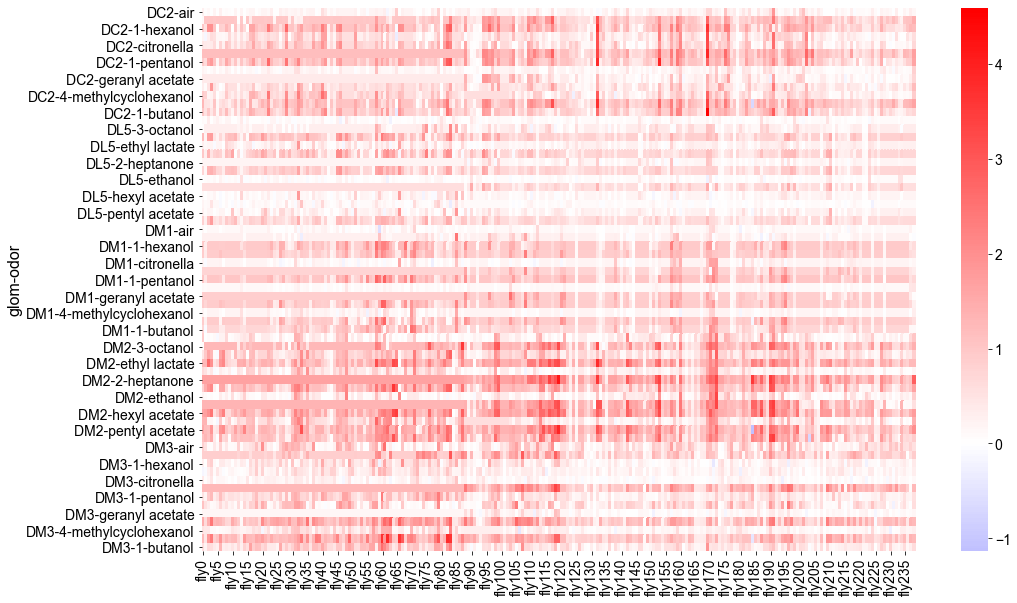

In [20]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(df_MAC_PN_responses, cmap='bwr', center=0, ax=ax)
plt.show()

In [21]:
fly_responses_df_MAC = df_MAC_PN_responses.loc[(gNames, oNames), :]
fly_responses_MAC = fly_responses_df_MAC.T.values

pca_MAC = PCA()
pca_MAC.fit(fly_responses_MAC)

pca_scores_MAC = pca_MAC.transform(fly_responses_MAC)
pca_loadings_MAC = pca_MAC.components_.T

pca_var_explained_MAC = pca_MAC.explained_variance_ratio_

In [22]:
fly_responses_df_MAC.shape

(65, 239)

In [23]:
pca_loadings_df_MAC = pd.DataFrame(pca_loadings_MAC, 
                                   index=fly_responses_df_MAC.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_MAC[i])}%)' for i in range(pca_loadings_MAC.shape[1])])

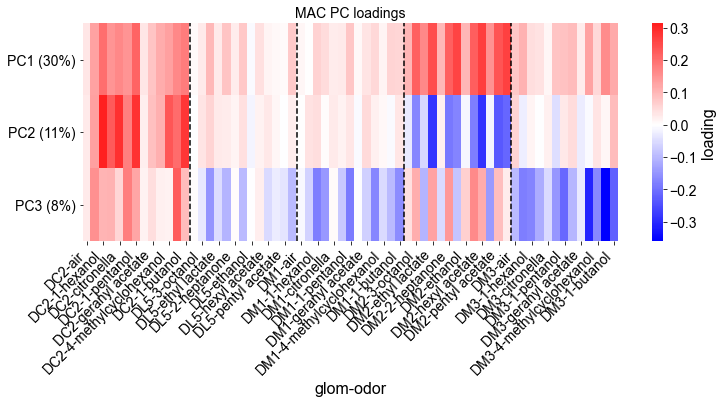

In [24]:
plt.figure(figsize=(12,4))
sns.heatmap(pca_loadings_df_MAC.iloc[:, :3].T, cmap='bwr', center=0, cbar_kws={'label': 'loading'})
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
for i in np.arange(13, 65, 13):
    plt.axvline(i, ls='--', c='k')
plt.title('MAC PC loadings')
plt.show()

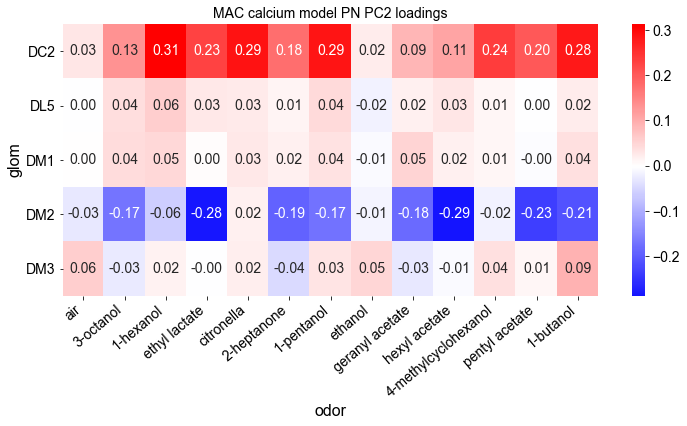

In [25]:
plt.figure(figsize=(12,5))
sns.heatmap(pd.DataFrame(pca_loadings_df_MAC.iloc[:, 1])
            .reset_index().pivot('glom', 'odor', 'PC2 (11%)')
            .loc[gNames, oNames],
            annot=True, fmt='.2f', center=0, cmap='bwr')
plt.yticks(rotation=0); plt.xticks(rotation=40, ha='right')
plt.title('MAC calcium model PN PC2 loadings')
plt.show()

Apples to apples comparison using the 11 odors in the simulation:

In [26]:
fly_responses_df_MAC = df_MAC_PN_responses.loc[(gNames, sim_odors), :]
fly_responses_MAC = fly_responses_df_MAC.T.values

pca_MAC = PCA()
pca_MAC.fit(fly_responses_MAC)

pca_scores_MAC = pca_MAC.transform(fly_responses_MAC)
pca_loadings_MAC = pca_MAC.components_.T

pca_var_explained_MAC = pca_MAC.explained_variance_ratio_

In [27]:
fly_responses_df_MAC.shape

(55, 239)

In [28]:
pca_loadings_df_MAC = pd.DataFrame(pca_loadings_MAC, 
                                   index=fly_responses_df_MAC.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_MAC[i])}%)' for i in range(pca_loadings_MAC.shape[1])])

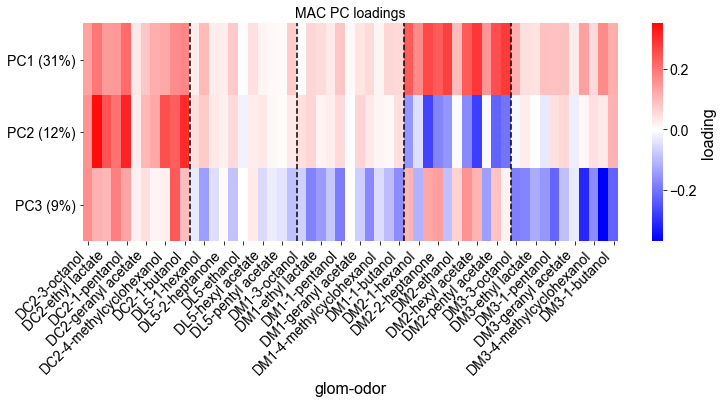

In [29]:
plt.figure(figsize=(12,4))
sns.heatmap(pca_loadings_df_MAC.iloc[:, :3].T, cmap='bwr', center=0, cbar_kws={'label': 'loading'})
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
for i in np.arange(11, 55, 11):
    plt.axvline(i, ls='--', c='k')
plt.title('MAC PC loadings')
plt.show()

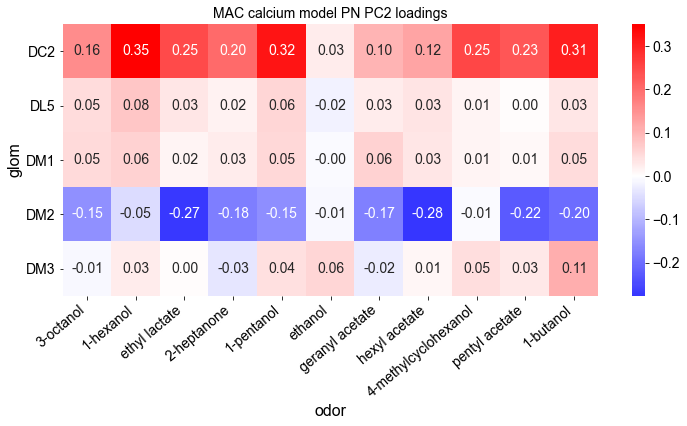

In [30]:
plt.figure(figsize=(12,5))
sns.heatmap(pd.DataFrame(pca_loadings_df_MAC.iloc[:, 1])
            .reset_index().pivot('glom', 'odor', 'PC2 (12%)')
            .loc[gNames, sim_odors],
            annot=True, fmt='.2f', center=0, cmap='bwr')
plt.yticks(rotation=0); plt.xticks(rotation=40, ha='right')
plt.title('MAC calcium model PN PC2 loadings')
plt.show()

## Simulation ORN+LN+PN resampling (with PN synapse density variation) responses

In [31]:
df_sim_resample_responses_nosubpre = list_of_df_responses_resamples_nosubpre[-1]
df_sim_resample_responses_subpre = list_of_df_responses_resamples_subpre[-1]

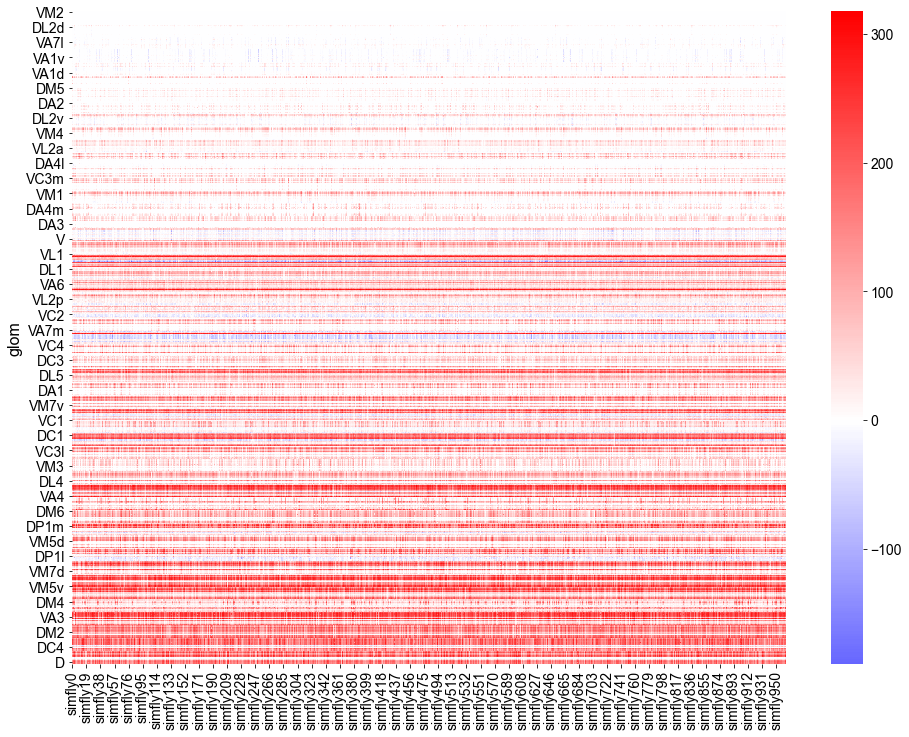

In [33]:
plot_df = df_sim_resample_responses_subpre
fly_columns = plot_df.columns
plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom').loc[:, fly_columns]
gloms_sorted = (plot_df.std(1)).groupby('glom').mean().sort_values().index.values

plt.figure(figsize=(16,12))
sns.heatmap(plot_df.loc[gloms_sorted], cmap='bwr', center=0)
plt.show()

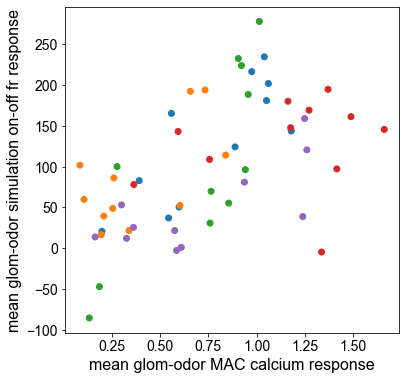

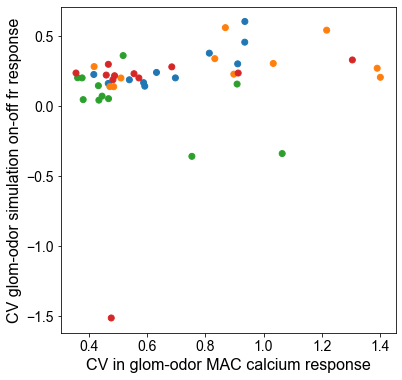

In [34]:
sim_response_means = df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :].mean(1)
MAC_response_means = df_MAC_PN_responses.loc[(gNames, sim_odors), :].mean(1)

glom_colors = {gNames[i]:f'C{i}' for i in range(len(gNames))}
scatter_colors = [glom_colors[g] for g in MAC_response_means.reset_index()['glom']]

plt.figure(figsize=(6,6))
plt.scatter(MAC_response_means, sim_response_means, c=scatter_colors)
plt.xlabel('mean glom-odor MAC calcium response')
plt.ylabel('mean glom-odor simulation on-off fr response')
plt.show()


sim_response_stds = df_sim_resample_responses_subpre.loc[(gNames[:-1], sim_odors), :].std(1)
MAC_response_stds = df_MAC_PN_responses.loc[(gNames[:-1], sim_odors), :].std(1)

sim_response_CVs = sim_response_stds / sim_response_means.loc[(gNames[:-1], sim_odors)]
MAC_response_CVs = MAC_response_stds / MAC_response_means.loc[(gNames[:-1], sim_odors)]
scatter_colors = [glom_colors[g] for g in MAC_response_CVs.reset_index()['glom']]

plt.figure(figsize=(6,6))
plt.scatter(MAC_response_CVs, sim_response_CVs, c=scatter_colors)
plt.xlabel('CV in glom-odor MAC calcium response')
plt.ylabel('CV glom-odor simulation on-off fr response')
plt.show()

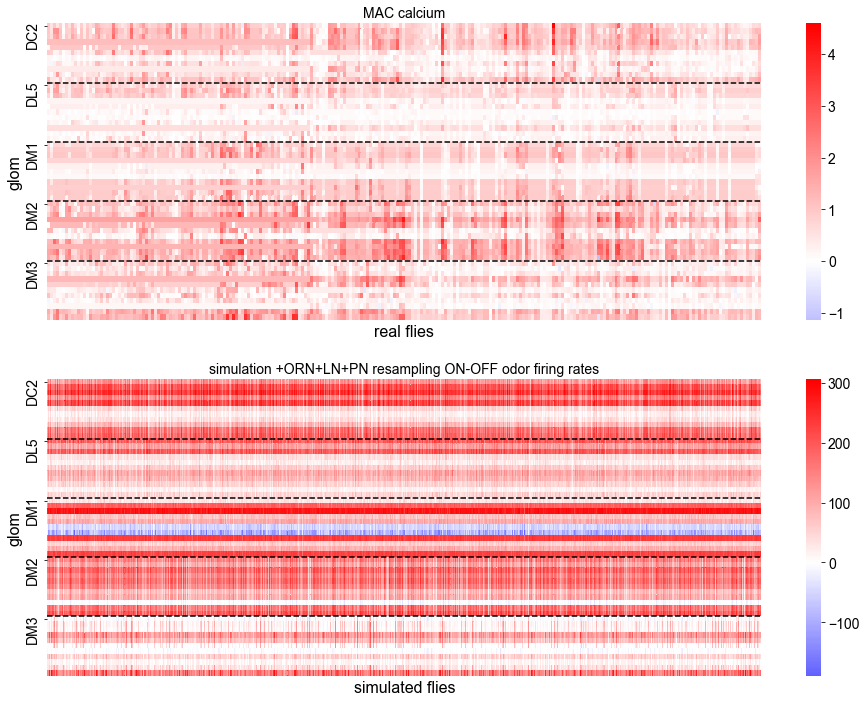

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(16,12))

# plot MAC
plot_df = df_MAC_PN_responses.loc[(gNames, sim_odors), :]
fly_columns = plot_df.columns
plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom').loc[:, fly_columns]
cols_sorted = plot_df.sum(0).sort_values().index.values[::-1]
sns.heatmap(plot_df,#.loc[:, cols_sorted], 
            xticklabels=5, yticklabels=11, cmap='bwr', center=0, ax=axs[0])

# plot sim
plot_df = df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :]
fly_columns = plot_df.columns
plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom').loc[:, fly_columns]
cols_sorted = plot_df.sum(0).sort_values().index.values[::-1]
sns.heatmap(plot_df,#.loc[:, cols_sorted], 
            xticklabels=5, yticklabels=11, cmap='bwr', center=0, ax=axs[1])

axs[0].set_title('MAC calcium'); axs[0].set_xlabel('real flies')
axs[1].set_title('simulation +ORN+LN+PN resampling ON-OFF odor firing rates'); axs[1].set_xlabel('simulated flies')

for ax in axs:
    for i in np.arange(11, 55, 11):
        ax.axhline(i, ls='--', c='k') 
    ax.set_xticks([])
plt.subplots_adjust(hspace=0.2)
plt.show()

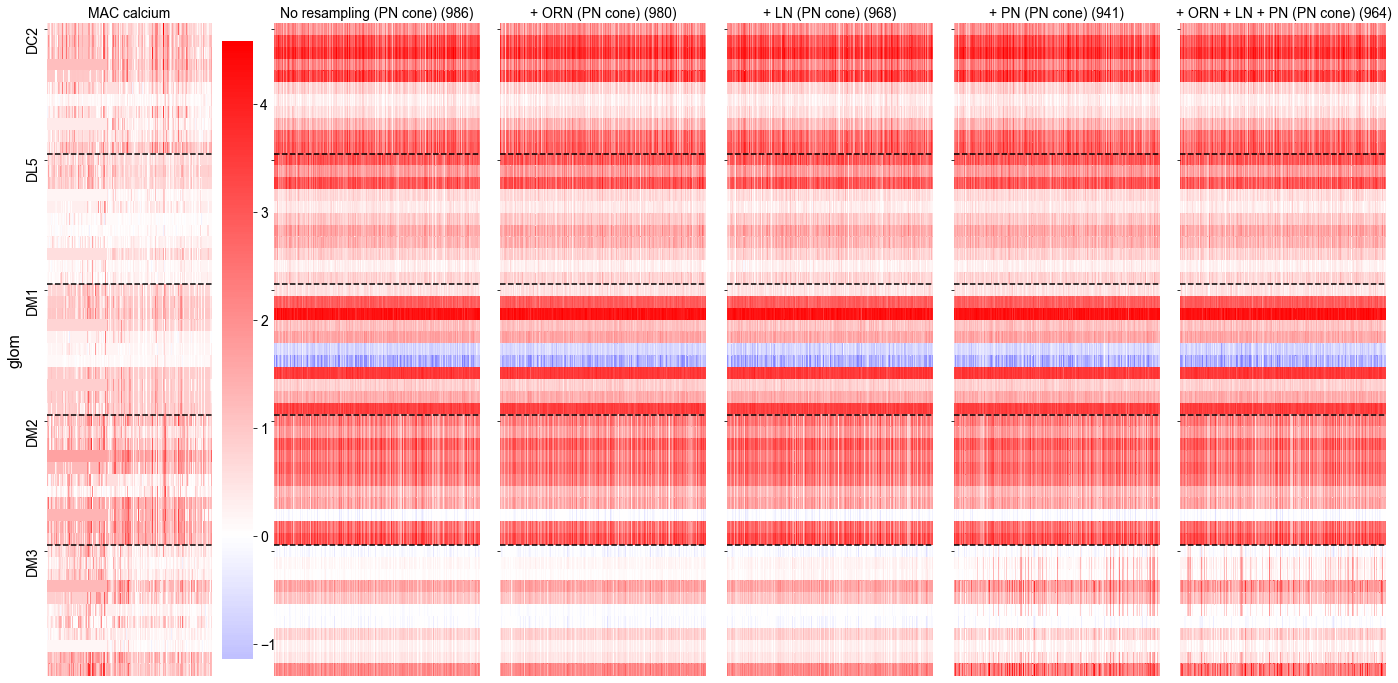

In [40]:
which_resample_sets = [0, 1, 2, 3, 4]
nplots = 1 + len(which_resample_sets)
fig, axs = plt.subplots(1, nplots, figsize=(nplots*4,12), sharey=True)

# plot MAC
plot_df = df_MAC_PN_responses.loc[(gNames, sim_odors), :]
fly_columns = plot_df.columns
plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom').loc[:, fly_columns]
cols_sorted = plot_df.sum(0).sort_values().index.values[::-1]
sns.heatmap(plot_df,#.loc[:, cols_sorted], 
            xticklabels=5, yticklabels=11, cmap='bwr', center=0, ax=axs[0])

# plot sim
for i in range(len(which_resample_sets)):
    ri = which_resample_sets[i]
    ax_i = i+1
    
    resample_name = set_names[ri]
    cur_title = f'{resample_name}'
    
    df_sim_resample_responses_subpre = list_of_df_responses_resamples_subpre[ri]
    plot_df = df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :]
    fly_columns = plot_df.columns
    plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom').loc[:, fly_columns]
    cols_sorted = plot_df.sum(0).sort_values().index.values[::-1]
    
    sns.heatmap(plot_df,#.loc[:, cols_sorted], 
                xticklabels=5, yticklabels=11, 
                vmin=-150, vmax=300, cbar=False, cmap='bwr', center=0, ax=axs[ax_i])
    axs[ax_i].set_title(cur_title)
    axs[ax_i].set_ylabel('')

axs[0].set_title('MAC calcium'); #axs[0].set_xlabel('real flies')
#axs[1].set_title('simulation , PN inputs adjusted by glomerular synapses, ON-OFF odor firing rates')
#axs[1].set_xlabel('simulated flies')

for ax in axs:
    for i in np.arange(11, 55, 11):
        ax.axhline(i, ls='--', c='k') 
    ax.set_xticks([])
plt.subplots_adjust(wspace=0.1)
plt.show()

In [41]:
save_tables = False
if save_tables:
    #df_MAC_responses.to_csv('MAC_fly_responses.csv')
    df_MAC_responses.loc[(gNames, sim_odors), :].to_csv('MAC_fly_responses.csv')

    #df_sim_resample_responses_subpre.to_csv('simulated_adjusted_fly_responses.csv')
    df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :].to_csv('simulated_adjusted_fly_responses.csv')

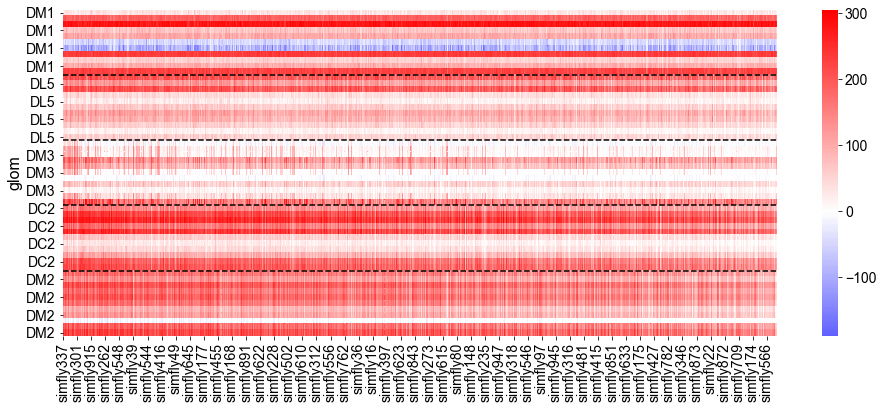

In [42]:
plot_df = df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :]
fly_columns = plot_df.columns
plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom').loc[:, fly_columns]
gloms_sorted = (plot_df.std(1)).groupby('glom').mean().sort_values().index.values

plt.figure(figsize=(16,6))
sns.heatmap(plot_df.loc[gloms_sorted, cols_sorted], cmap='bwr', center=0)
plt.yticks(rotation=0)
for i in np.arange(11, 55, 11):
    plt.axhline(i, ls='--', c='k') 
plt.show()

In [43]:
fly_responses_df_sim_allgloms = df_sim_resample_responses_subpre.loc[(hemi_gloms, sim_odors), :]
fly_responses_sim_allgloms = fly_responses_df_sim_allgloms.T.values

pca_sim_allgloms = PCA()
pca_sim_allgloms.fit(fly_responses_sim_allgloms)

pca_scores_sim_allgloms = pca_sim_allgloms.transform(fly_responses_sim_allgloms)
pca_loadings_sim_allgloms = pca_sim_allgloms.components_.T

pca_var_explained_sim_allgloms = pca_sim_allgloms.explained_variance_ratio_

In [44]:
fly_responses_df_sim_macgloms = df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :]
fly_responses_sim_macgloms = fly_responses_df_sim_macgloms.T.values

pca_sim_macgloms = PCA()
pca_sim_macgloms.fit(fly_responses_sim_macgloms)

pca_scores_sim_macgloms = pca_sim_macgloms.transform(fly_responses_sim_macgloms)
pca_loadings_sim_macgloms = pca_sim_macgloms.components_.T

pca_var_explained_sim_macgloms = pca_sim_macgloms.explained_variance_ratio_

In [45]:
pca_loadings_df_sim_allgloms = pd.DataFrame(pca_loadings_sim_allgloms, 
                                   index=fly_responses_df_sim_allgloms.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_sim_allgloms[i])}%)' for i in range(pca_loadings_sim_allgloms.shape[1])])
pca_loadings_df_sim_macgloms = pd.DataFrame(pca_loadings_sim_macgloms, 
                                   index=fly_responses_df_sim_macgloms.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_sim_macgloms[i])}%)' for i in range(pca_loadings_sim_macgloms.shape[1])])

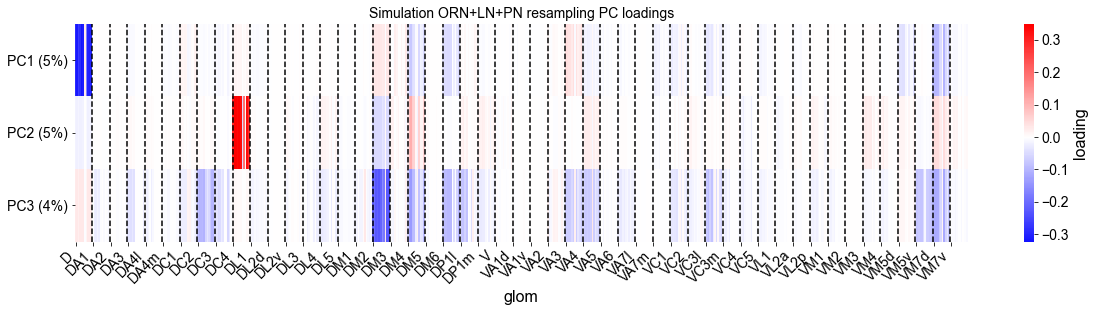

In [46]:
plot_df = pca_loadings_df_sim_allgloms
pc_columns = plot_df.columns
plot_df = plot_df.reset_index().sort_values(['glom', 'odor']).set_index('glom')[pc_columns]

plt.figure(figsize=(20,4))
sns.heatmap(plot_df.iloc[:, :3].T, cmap='bwr', xticklabels=11, center=0, cbar_kws={'label': 'loading'})
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
for i in np.arange(11, 51*11, 11):
    plt.axvline(i, ls='--', c='k')
plt.title('Simulation ORN+LN+PN resampling PC loadings')
plt.show()

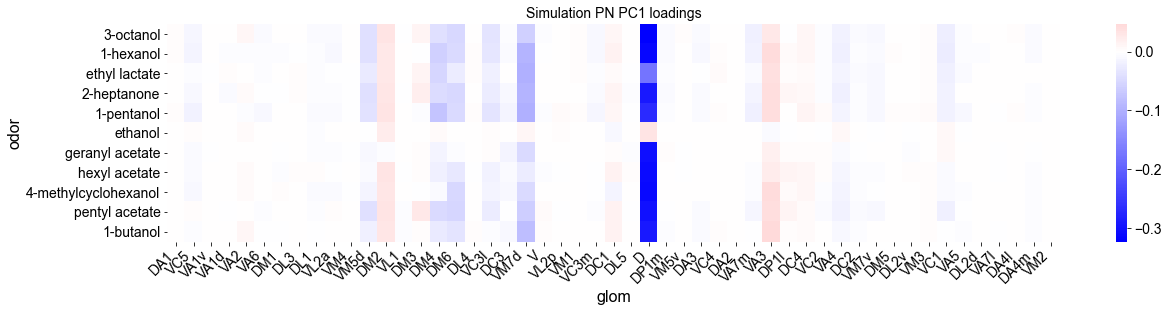

In [47]:
plt.figure(figsize=(20,4))
sns.heatmap(pd.DataFrame(pca_loadings_df_sim_allgloms.iloc[:, 0])
            .reset_index().pivot('glom', 'odor', 'PC1 (5%)')
            .loc[hemi_gloms, sim_odors].T,
            annot=False, fmt='.2f', xticklabels=1, center=0, cmap='bwr')
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
plt.title('Simulation PN PC1 loadings')
plt.show()

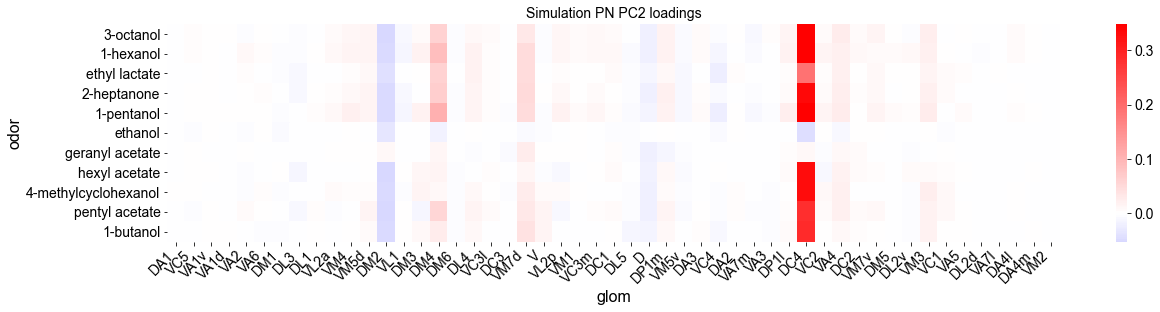

In [48]:
plt.figure(figsize=(20,4))
sns.heatmap(pd.DataFrame(pca_loadings_df_sim_allgloms.iloc[:, 1])
            .reset_index().pivot('glom', 'odor', 'PC2 (5%)')
            .loc[hemi_gloms, sim_odors].T,
            annot=False, fmt='.2f', xticklabels=1, center=0, cmap='bwr')
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
plt.title('Simulation PN PC2 loadings')
plt.show()

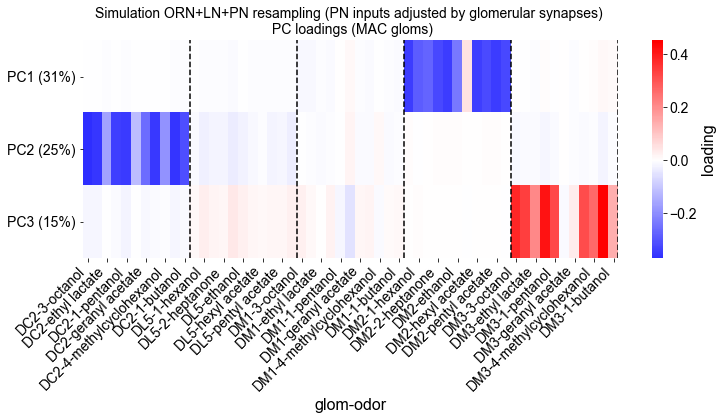

In [49]:
plt.figure(figsize=(12,4))
sns.heatmap(pca_loadings_df_sim_macgloms.iloc[:, :3].T, cmap='bwr', center=0, cbar_kws={'label': 'loading'})
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
for i in np.arange(11, 51*11, 11):
    plt.axvline(i, ls='--', c='k')
plt.title('Simulation ORN+LN+PN resampling (PN inputs adjusted by glomerular synapses) \n PC loadings (MAC gloms)')
plt.show()

## Loadings

In [51]:
from scipy.stats import pearsonr

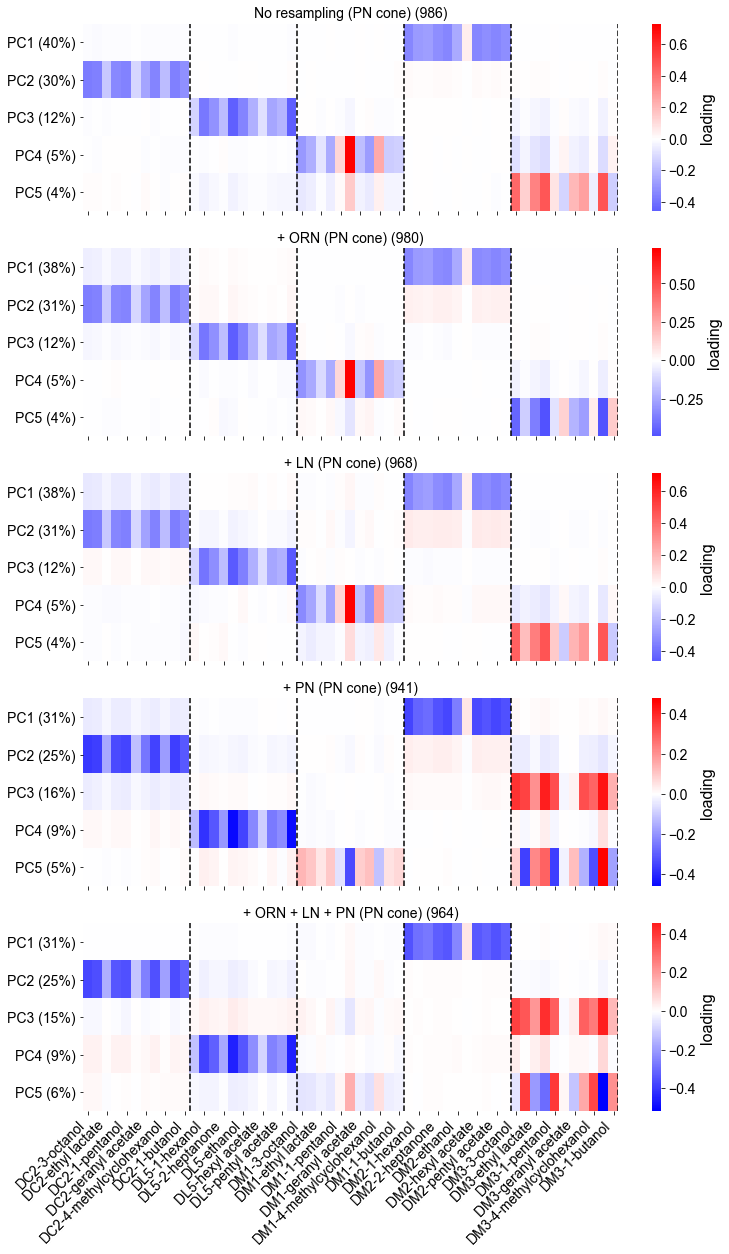

In [52]:
which_resample_sets = [0, 1, 2, 3, 4]
nplots = len(which_resample_sets)

all_pca_loadings = {}
all_pca_vars_explained = {}
all_sim_frs = {}

fig, axs = plt.subplots(nplots, 1, sharex=True, figsize=(12, nplots*4))

rs_plots = {}
for i in range(len(which_resample_sets)):
    ri = which_resample_sets[i]
    ax_i = i
    
    resample_name = set_names[ri]
    cur_title = f'{resample_name}'
    
    df_sim_resample_responses_subpre = list_of_df_responses_resamples_subpre[ri]
    
    ## do PCA   
    fly_responses_df_sim_macgloms = df_sim_resample_responses_subpre.loc[(gNames, sim_odors), :]
    fly_responses_sim_macgloms = fly_responses_df_sim_macgloms.T.values

    pca_sim_macgloms = PCA()
    pca_sim_macgloms.fit(fly_responses_sim_macgloms)

    pca_scores_sim_macgloms = pca_sim_macgloms.transform(fly_responses_sim_macgloms)
    pca_loadings_sim_macgloms = pca_sim_macgloms.components_.T

    pca_var_explained_sim_macgloms = pca_sim_macgloms.explained_variance_ratio_
    
    
    pca_loadings_df_sim_macgloms = pd.DataFrame(pca_loadings_sim_macgloms, 
                                   index=fly_responses_df_sim_macgloms.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_sim_macgloms[i])}%)' for i in range(pca_loadings_sim_macgloms.shape[1])])
    
    # get rs plots
    pcis = 55
    rs_mac_sim = []
    for pci in range(1, pcis):
        cur_r = pearsonr(pca_loadings_df_MAC.iloc[:, pci], 
                         pca_loadings_df_sim_macgloms.iloc[:, pci-1])[0]
        rs_mac_sim.append(cur_r)
    rs_mac_sim = np.array(rs_mac_sim)
    
    all_pca_loadings[resample_name] = pca_loadings_df_sim_macgloms
    all_pca_vars_explained[resample_name] = pca_var_explained_sim_macgloms
    all_sim_frs[resample_name] = fly_responses_df_sim_macgloms
    
    rs_plots[resample_name] = rs_mac_sim
    #plt.figure(figsize=(12,4))
    sns.heatmap(pca_loadings_df_sim_macgloms.iloc[:, :5].T, 
                cmap='bwr', center=0, cbar_kws={'label': 'loading'},
                ax=axs[ax_i])
    for i in np.arange(11, 51*11, 11):
        axs[ax_i].axvline(i, ls='--', c='k')
    axs[ax_i].set_title(f'{cur_title}')#' (PN inputs adjusted by glomerular synapses) \n PC loadings (MAC gloms)')
    axs[ax_i].set_xlabel('')
    #plt.show()
    
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
plt.show()

In [53]:
do_MAC_bootstrap = 1
n_MAC_bootstraps = 10
n_MAC_flies_to_bootstrap = 150
mac_bootstrap_PCAs = []

if do_MAC_bootstrap:
    for fi in range(n_MAC_bootstraps):
        fly_sample = np.random.choice(np.arange(len(fly_responses_MAC)), n_MAC_flies_to_bootstrap)#, replace=False)
        pca_MAC_bootstrap = PCA()
        pca_MAC_bootstrap.fit(fly_responses_MAC[fly_sample])
        pca_loadings_MAC_bootstrap = pca_MAC_bootstrap.components_.T
        pca_loadings_df_MAC_bootstrap = pd.DataFrame(pca_loadings_MAC_bootstrap, 
                                   index=fly_responses_df_MAC.index, 
                                   columns=[f'PC{i+1} ({int(100*pca_var_explained_MAC[i])}%)' for i in range(pca_loadings_MAC.shape[1])])
        mac_bootstrap_PCAs.append(pca_loadings_df_MAC_bootstrap)

In [54]:
conds = ['No resampling (PN cone)', 
         '+ ORN (PN cone)', 
         '+ LN (PN cone)', 
         '+ PN (PN cone)', 
         '+ ORN + LN + PN (PN cone)']
conds = set_names
nconds = len(conds)

In [55]:
nplot = 10

d_cond_grids = {}
d_cond_MAC_bootstrap_grids = {}

for ic in range(nconds):  
    # retrieve PCA loadings for this condition
    cond = conds[ic]
    pca_loadings = all_pca_loadings[cond]
    
    # fill a grid of simulation vs. MAC loading correlations
    
    if do_MAC_bootstrap: 
        rs_grids_bootstrap = [np.zeros((nplot, nplot)) for x in range(n_MAC_bootstraps)]
    
    rs_grid = np.zeros((nplot, nplot))
    for i in range(nplot):
        for j in range(nplot):
            rs_grid[i, j] = np.abs(pearsonr(pca_loadings.iloc[:, i],
                                     pca_loadings_df_MAC.iloc[:, j])[0])
            
            if do_MAC_bootstrap:
                for k in range(n_MAC_bootstraps):
                    rs_grids_bootstrap[k][i, j] = np.abs(pearsonr(pca_loadings.iloc[:, i],
                                     mac_bootstrap_PCAs[k].iloc[:, j])[0])
            
    # make into dataframes            
    row_labs = [f'sim_PC_{i+1}' for i in range(nplot)]
    col_labs = [f'MAC_PC_{i+1}' for i in range(nplot)]
    d_cond_grids[cond] = pd.DataFrame(rs_grid, index=row_labs, columns=col_labs)
    d_cond_grids[cond+'_var_explained'] = all_pca_vars_explained[cond]
    
    if do_MAC_bootstrap:
        d_cond_MAC_bootstrap_grids[cond] = [pd.DataFrame(rs_grid_b, index=row_labs, columns=col_labs) \
                                            for rs_grid_b in rs_grids_bootstrap]

In [57]:
save_results = 1
saveto_dir = 'PCA_analysis/'
if not os.path.isdir(saveto_dir):
    os.makedirs(saveto_dir)

In [62]:
if save_results:
    #pickle.dump(d_cond_MAC_bootstrap_grids, open(os.path.join(saveto_dir, 'sim_MAC_PCA_resampling_and_cone_bootstrap.p'), 'wb'))
    pickle.dump(d_cond_grids, open(os.path.join(saveto_dir, 'sim_MAC_PCA_resampling_PNdensity.p'), 'wb'))
    pickle.dump(all_pca_loadings, open(os.path.join(saveto_dir, 'sim_PCA_loadings_resampling_PNdensity.p'), 'wb'))
    pickle.dump(all_sim_frs, open(os.path.join(saveto_dir, 'sim_firing_rates_resampling_PNdensity.p'), 'wb'))